# INFO: Calculate SNR of GPR B-Scan signal

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import csv

from numpy.linalg import eig, inv

plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

## Data Injection

In [2]:

# Read the noise .csv file, Header has 4 lines above the data, so skip the first 4 lines
# Data has 5 columns, 4th column is S21(dBm/dBm), and each data records 201 points(20MHz-170MHz)
# Notice that there is an END string after the last line of data, so we need to skip the last line
# raw_data = np.genfromtxt(r"C:\Users\unive\Desktop\9-9'_csv_[1]_[2]_[3]_[4]_[5]_DATA_out.csv", delimiter=',', skip_header=4, skip_footer=0)
# raw_s21_real = raw_data[:, 3] # sorted as A-Scan_1, A-Scan_2, A-Scan_3, ...

#****************************数据处理后******************************
# NEW DATA format, csv file contains the b-scan array, no headers, has 501 rows(time), unknown columns(A-Scan unit)
raw_data = np.genfromtxt(r"C:\Users\unive\Desktop\LineL1origin(20)_csv_DATA.csv", delimiter=',', skip_header=0, skip_footer=0)
processed_data = np.genfromtxt(r"C:\Users\unive\Desktop\LineL1origin(20)_csv_[3]_[4]_[5]_DATA.csv", delimiter=',', skip_header=0, skip_footer=0)

## Function Definition

In [7]:

# separate the raw_s21_real list into a numpy array(b_scan matrix, the row axis is time, the column axis is A-Scan unit)
# raw_s21_real format is [A-Scan_1, A-Scan_2, A-Scan_3, ...], each A-Scan has 501 points(from 0-700ns)
# b_scan = np.array(raw_s21_real).reshape(501, -1)
# print the dimension of b_scan to check the row&col is right
# print(b_scan.shape)

# TODO: CHECK the algorithm after our project finished
# 1. time-index conversion
def time_to_point(time, start_time, end_time, ascan_points):
    """
    Calculate the mapping relationship between "time and row index"
    Time unit: ns
    """
    time_range = end_time - start_time
    point_converted = int(time / time_range * ascan_points)
    # print(f"time: {time}, mapped to point: {point_converted}")
    return point_converted

def point_to_time(point, start_time, end_time, ascan_points):
    """
    Calculate the mapping relationship between "point and time"
    Time unit: ns
    """
    time_range = end_time - start_time
    time_converted = point / ascan_points * time_range
    # print(f"point: {point}, mapped to time: {time_converted}")
    return time_converted

#***************************B-Scan成像******************************
def BScan_plot(b_scan, time_start=0, time_end=700, title='B-Scan Grayscale Plot', annotations=None):
    """
    绘制B-Scan图像的通用函数，并可选择性地添加标注区域

    参数:
    b_scan: numpy数组，B-Scan数据矩阵
    time_start: 起始时间(ns)，默认0
    time_end: 结束时间(ns)，默认700
    title: 图像标题，默认'B-Scan Grayscale Plot'
    annotations: 可选，一个包含标注信息的列表，每个元素为字典:
                 {'time_range': (start_time, end_time), 'scan_range': (start_scan, end_scan), 'color': 'color', 'label': 'label'}
    """
    # 计算时间和扫描范围
    time_points = b_scan.shape[0]
    time_range = np.linspace(time_start, time_end, time_points)
    scan_range = np.arange(1, b_scan.shape[1] + 1)

    # 创建图像
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(b_scan, cmap='gray', aspect='auto',
                   extent=[scan_range[0], scan_range[-1], time_range[-1], time_range[0]])

    # 设置坐标轴
    ax.set_xlabel('A-Scan Unit')
    ax.set_ylabel('Time (ns)')
    ax.set_title(title)
    plt.colorbar(im, ax=ax)

    # 添加标注区域
    if annotations:
        for ann in annotations:
            time_range_ann = ann['time_range']
            scan_range_ann = ann['scan_range']
            color = ann.get('color', 'red')
            label = ann.get('label', '')

            # 处理time_range为None的情况（使用整个时间轴范围）
            if time_range_ann is None:
                time_range_ann = (time_start, time_end)

            # 处理scan_range为None的情况（使用整个A-Scan范围）
            if scan_range_ann is None:
                scan_range_ann = (scan_range[0], scan_range[-1])

            # 计算矩形的左下角坐标和宽度、高度
            x = scan_range_ann[0]
            y = time_range_ann[0]
            width = scan_range_ann[1] - scan_range_ann[0]
            height = time_range_ann[1] - time_range_ann[0]

            # 创建并添加矩形
            rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor=color, facecolor='none', label=label)
            ax.add_patch(rect)

            # 添加标签
            if label:
                ax.text(x, y, label, color=color, fontsize=10,
                    verticalalignment='bottom', horizontalalignment='left',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))

    # plt.show(block=False)  # 非阻塞显示
    return ax  # 返回轴对象，以便外部可以进一步操作

# 使用示例：
# BScan_plot(raw_data, 0, 700, 'Original B-Scan')
# BScan_plot(b_scan_power, 0, 700, 'B-Scan Power Plot')
# BScan_plot(X_prime_real, 0, 700, 'SGC-Preprocessed B-Scan')

def annotate_bscan_region(ax, time_range=None, scan_range=None, color='red', linewidth=2, label=None):
    """
    在B-Scan图像上标注特定区域

    参数:
    ax: matplotlib轴对象
    time_range: 时间范围元组 (start_time, end_time)，默认None（自动获取图像y轴范围）
    scan_range: A-Scan范围元组 (start_scan, end_scan)，默认None（自动获取图像x轴范围）
    color: 边框颜色，默认为红色
    linewidth: 边框线宽
    label: 标签文本
    """
    # 如果未提供time_range，使用图像y轴的完整范围
    if time_range is None:
        y_lim = ax.get_ylim()
        time_range = (y_lim[1], y_lim[0])  # 注意imshow的y轴方向

    # 如果未提供scan_range，使用图像x轴的完整范围
    if scan_range is None:
        x_lim = ax.get_xlim()
        scan_range = (x_lim[0], x_lim[1])

    # 获取区域坐标
    x_start, x_end = scan_range
    y_start, y_end = time_range

    # 绘制矩形框
    from matplotlib.patches import Rectangle
    rect = Rectangle((x_start, y_start), x_end - x_start, y_end - y_start,
                     linewidth=linewidth, edgecolor=color, facecolor='none', label=label)
    ax.add_patch(rect)

    # 添加标签（如果提供）
    if label:
        ax.text(x_start, y_start, label, color=color, fontsize=10,
                verticalalignment='bottom', horizontalalignment='left',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))


# 使用示例：
# 假设你已经有了B-Scan图像的轴对象ax
# annotate_bscan_region(ax, (100, 200), (500, 1000), color='yellow', label='Noise Region')
# annotate_bscan_region(ax, (400, 500), (1200, 1800), color='blue', label='Target Region')

#******************************SNR计算(均值)******************************
def calculate_SNR(b_scan_power, noise_time_range, target_time_range, time_params=(0, 700, 501)):
    """
        计算B-Scan数据的信噪比(SNR)

        参数:
        b_scan_power: numpy数组，B-Scan功率数据矩阵
        noise_time_range: 元组，噪声区域时间范围(start, end)，例如(100, 200)
        target_time_range: 元组，目标区域时间范围(start, end)，例如(400, 500)
        time_params: 元组，时间参数(start_time, end_time, ascan_points)，默认(0, 700, 501)

        返回:
        SNR_dB: float，信噪比(dB)
        SNR_linear: float，信噪比(线性)
        """
    start_time, end_time, ascan_points = time_params

    # 提取噪声区域数据
    noise_start = time_to_point(noise_time_range[0], start_time, end_time, ascan_points)
    noise_end = time_to_point(noise_time_range[1], start_time, end_time, ascan_points)
    noise_power = b_scan_power[noise_start:noise_end]

    # 提取目标区域数据
    target_start = time_to_point(target_time_range[0], start_time, end_time, ascan_points)
    target_end = time_to_point(target_time_range[1], start_time, end_time, ascan_points)
    target_power = b_scan_power[target_start:target_end]

    # 计算平均功率
    noise_mean = noise_power.mean()
    target_mean = target_power.mean()

    # 计算SNR
    # signal_eff = target_mean - noise_mean
    signal_eff = target_mean
    SNR_linear = signal_eff / noise_mean
    SNR_dB = 10 * np.log10(SNR_linear)

    print(f"noise mean: {noise_mean}")
    print(f"target mean: {target_mean}")
    print(f"signal_effective: {signal_eff}")
    print(f"SNR_linear: {SNR_linear}, SNR_dB: {SNR_dB}")

    return SNR_dB, SNR_linear

# TCR目标杂波比 20lg_10((1/N_T * \sum (p,q)属于T |X(p,q)|^2)/(1/N_C * \sum (p,q)属于C |X(p,q)|^2))
#*****************************TCR计算******************************
def calculate_TCR(b_scan, noise_time_range, target_time_range, time_params=(0, 700, 501)):
    """
    计算探地雷达（GPR）B-Scan数据的目标杂波比（TCR）
    计算公式参考文档：TCR(dB) = 20*log10(目标区域平均功率 / 杂波区域平均功率)

    参数：
    b_scan: np.array，形状为(501, 2383)的B-Scan矩阵，行对应0-700ns，列对应2383个A-Scan
    noise_time_range: 元组，噪声区域时间范围(start, end)，例如(100, 200)
    target_time_range: 元组，目标区域时间范围(start, end)，例如(400, 500)
    time_params: 元组，时间参数(start_time, end_time, ascan_points)，默认(0, 700, 501)

    返回：
    tcr_db: float，TCR值（单位：dB）
    """
    start_time, end_time, ascan_points = time_params

    # 1. 定义杂波区域：使用传入的noise_time_range参数
    clutter_row_start = time_to_point(noise_time_range[0], start_time, end_time, ascan_points)
    clutter_row_end = time_to_point(noise_time_range[1], start_time, end_time, ascan_points)
    # 提取杂波区域数据：所有列的杂波行
    clutter_region = b_scan[clutter_row_start:clutter_row_end + 1, :]

    # 2. 定义目标区域：使用传入的target_time_range参数
    target_row_start = time_to_point(target_time_range[0], start_time, end_time, ascan_points)
    target_row_end = time_to_point(target_time_range[1], start_time, end_time, ascan_points)
    # 提取目标区域数据：所有列的目标行
    target_region = b_scan[target_row_start:target_row_end + 1, :]

    # 3. 计算目标区域平均功率（像素强度平方的均值）
    # 文档定义：目标区域平均功率 = (1/N_T) * Σ|X(p,q)|²，其中N_T为目标区域像素数
    target_power = np.mean(np.square(np.abs(target_region)))
    N_T = target_region.size  # 目标区域总像素数（行数×列数）

    # 4. 计算杂波区域平均功率
    # 文档定义：杂波区域平均功率 = (1/N_C) * Σ|X(p,q)|²，其中N_C为杂波区域像素数
    clutter_power = np.mean(np.square(np.abs(clutter_region)))
    N_C = clutter_region.size  # 杂波区域总像素数

    # 5. 计算TCR（避免除以零，添加微小值）
    epsilon = 1e-10  # 防止杂波功率为0导致计算错误
    tcr_db = 20 * np.log10((target_power + epsilon) / (clutter_power + epsilon))

    return tcr_db

## Data Processing

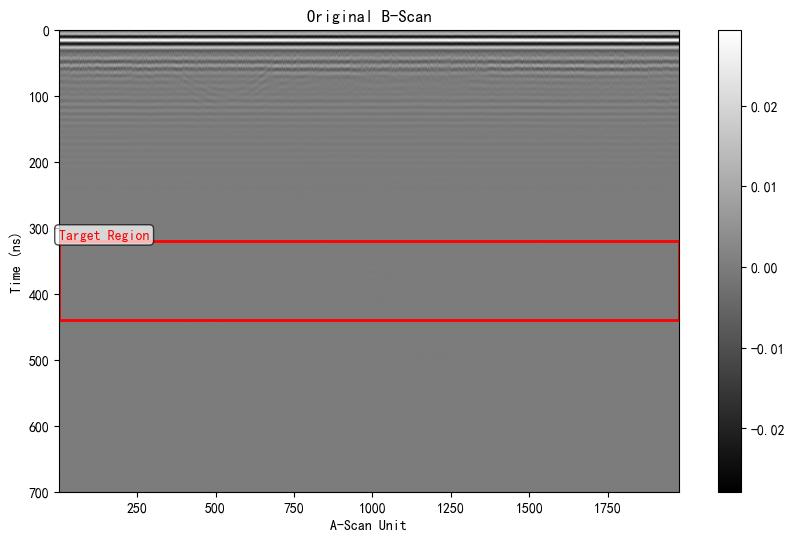

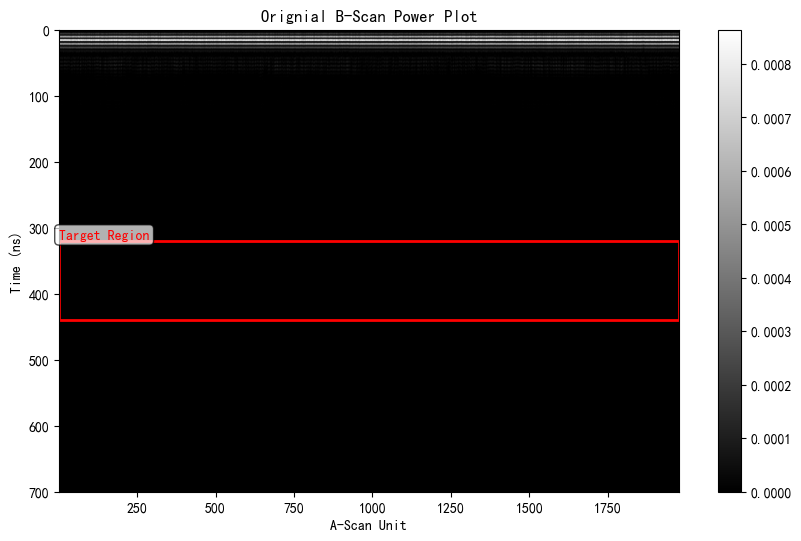

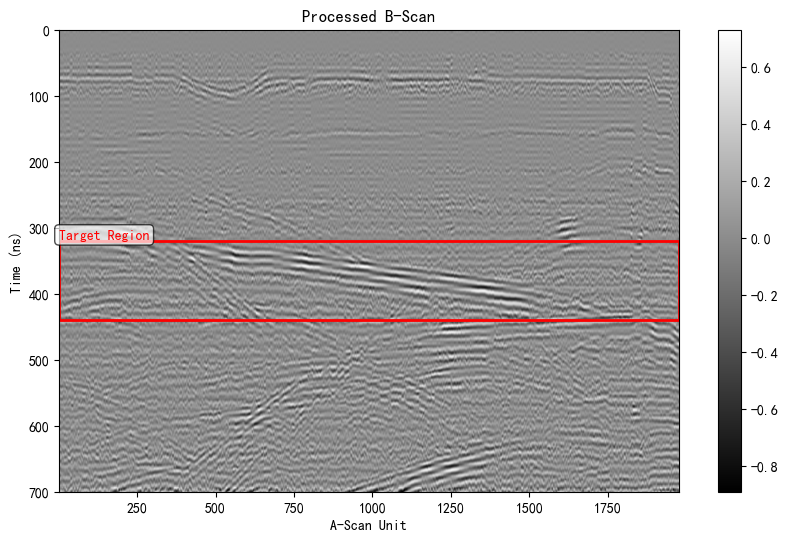

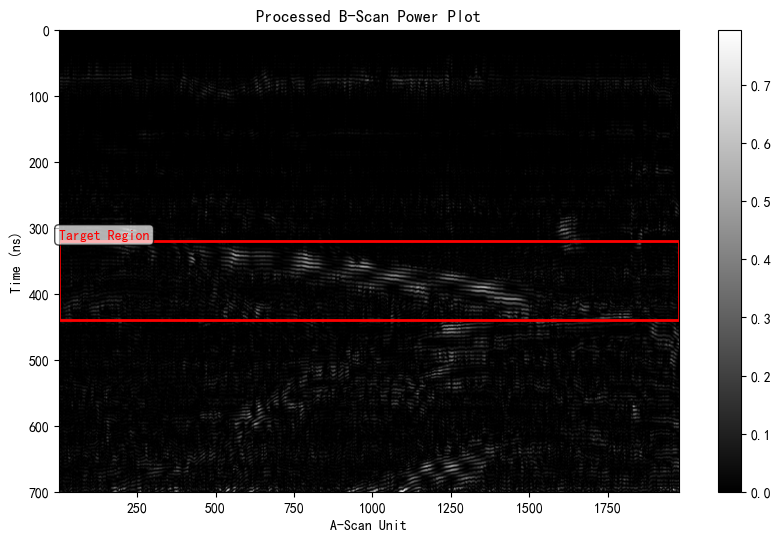

In [53]:
# S21 Real（网络参数实部）是 “电压传输系数的实部”（幅度维度，可正可负），而非 “功率比值”，直接按之前的功率比逻辑计算会因 “负值 / 零值” 导致对数转换出现 NaN。
b_scan_power = raw_data ** 2
b_scan_proc_power = processed_data ** 2

# 定义标注区域
annotations = [
    # {
    #     'time_range': (120, 200),
    #     'scan_range': None,
    #     'color': 'yellow',
    #     'label': 'Noise Region'
    # },
    {
        'time_range': (320, 440), #350 500
        'scan_range': None,
        'color': 'red',
        'label': 'Target Region'
    }
]

# # 调用修改后的函数
# BScan_plot(raw_data, 0, 700, 'Original B-Scan with Annotations', annotations)

# draw the b_scan grayscale plot to check the data
ax = BScan_plot(raw_data, 0, 700, 'Original B-Scan', annotations)
# annotate_bscan_region(ax, None, (500, 1000), color='yellow', label='Noise Region')
plt.show()
BScan_plot(b_scan_power, 0, 700, 'Orignial B-Scan Power Plot', annotations)
plt.show()
BScan_plot(processed_data, 0, 700, 'Processed B-Scan', annotations)
plt.savefig(r"C:\Users\unive\Desktop\L1号测线处理后的b_scan(170, 180)_(320, 440).png")
plt.show()
BScan_plot(b_scan_proc_power, 0, 700, 'Processed B-Scan Power Plot', annotations)
plt.savefig(r"C:\Users\unive\Desktop\L1号测线处理后的b_scan功率(170, 180)_(320, 440).png")
plt.show()

In [54]:

# 使用示例：
# SNR_dB, SNR_linear = calculate_SNR(b_scan_power, (120, 200), (400, 500))
# print("原始数据结果：")
# SNR_dB1, SNR_linear1 = calculate_SNR(b_scan_power, (120, 200), (360, 480)) #line9
# raw_data_tcr_result = calculate_TCR(raw_data, (120, 200), (360, 480))
# print(f"原始数据TCR值：{raw_data_tcr_result:.2f} dB")

print("处理后的结果：")
SNR_dB2, SNR_linear2 = calculate_SNR(b_scan_proc_power, (170, 180), (320, 440))
processed_data_tcr_result = calculate_TCR(processed_data, (170, 180), (320, 440))
print(f"处理后的TCR值：{processed_data_tcr_result:.2f} dB")


处理后的结果：
noise mean: 0.0020269574929811973
target mean: 0.029311615231768395
signal_effective: 0.029311615231768395
SNR_linear: 14.46089290637152, SNR_dB: 11.601951098559976
处理后的TCR值：23.04 dB



### SGC增益论文复现测试

In [ ]:

# 1. 输入B-scan矩阵X（你的数据）
X = raw_data  # 维度：(m=501, n=2383)
m, n = X.shape

# 2. 计算X_sym = X^T · X（步骤1 of Algorithm 1）
X_sym = X.T @ X  # 维度：(n=2383, n=2383)

# 3. 求解X_sym的特征值λ_i和右特征向量v_i（步骤2 of Algorithm 1）
# 注：X^T X的特征值=X的奇异值²，右特征向量=X的右奇异向量V
eigenvalues, V = eig(X_sym)  # eigenvalues: (2383,), V: (2383, 2383)

# 4. 对特征值按降序排序，同步调整右特征向量（步骤3 of Algorithm 1）
sorted_idx = np.argsort(eigenvalues)[::-1]  # 从大到小排序的索引
sorted_lambda = eigenvalues[sorted_idx]     # 排序后的特征值
V_sorted = V[:, sorted_idx]                 # 排序后的右奇异向量V

# 5. 计算奇异值σ_i = √λ_i，构造对角矩阵Σ（步骤4-5 of Algorithm 1）
k_n = min(m, n)  # 奇异值总数：min(501,2383)=501（论文中k_n定义）
sigma = np.sqrt(sorted_lambda[:k_n])  # 取前k_n个特征值的平方根（避免冗余）
Sigma = np.diag(sigma)                # 对角矩阵Σ：(k_n=501, k_n=501)

# 6. 计算左奇异向量U = X · V_sorted[:,:k_n] · Σ⁻¹（步骤7 of Algorithm 1）
# 仅取V_sorted的前k_n列（与Σ维度匹配），Σ⁻¹为对角矩阵的逆（元素=1/σ_i）
V_k = V_sorted[:, :k_n]  # (2383, 501)
Sigma_inv = inv(Sigma)   # (501, 501)
U = X @ V_k @ Sigma_inv  # 左奇异向量U：(501, 501)

# 7. 构造权重矩阵W（公式6，步骤8 of Algorithm 1）
# W维度：(1, k_n=501)，元素为[1, (1-1/k_n), (1-2/k_n), ..., 1/k_n]
w_values = np.array([1 - i/k_n for i in range(k_n)])  # 长度501的权重序列
# 8. 转换为对角矩阵（501×501），确保与U、Sigma维度适配
W_diag = np.diag(w_values)  # 修正后：W_diag维度(501,501)

# 重新计算噪声抑制项term（维度匹配）
# U(501×501) @ W_diag(501×501) → 501×501
# 再 @ Sigma(501×501) → 501×501
# 再 @ V_k.T(501×2383) → 501×2383（与X维度一致）
term = U @ W_diag @ Sigma @ V_k.T  # 修正后无维度错误
X_prime = X - term  # SGC预处理结果（501×2383）
print(f"X_prime shape:{X_prime.shape}")

freq_points = 501  # 行数量（频点）
time_window = 700  # 总时窗（ns）
time_axis = np.linspace(0, time_window, freq_points)  # 纵轴时间值：[0, 700]ns，共501个点
ascan_axis = np.arange(X_prime.shape[1])  # 横轴A-Scan道数：0~2837
# 创建画布（论文中图像为单幅或多幅对比，此处以单幅SGC结果为例）
fig, ax = plt.subplots(figsize=(12, 6))  # 宽=12（适配2838道A-Scan），高=6（适配501个频点）

# 绘制B-Scan热力图：extent参数定义坐标轴范围（左,右,下,上）
# 注意：matplotlib的imshow默认“行=纵轴”，需将时间轴作为纵轴，且原点在下方（符合“时间从0开始向上递增”）
# 关键修正：将复数B-scan转换为实数值（取信号幅值）
X_prime_real = np.abs(X_prime)  # 此时X_prime_real为float64类型，符合imshow要求
print(X_prime_real.dtype)  # 输出应为float64或float32，确保无complex类型
# 后续绘制用X_prime_real替代X_prime
im = ax.imshow(
    np.flipud(X_prime_real),
    extent=[ascan_axis[0], ascan_axis[-1], time_axis[-1], time_axis[0]],
    origin='lower',
    cmap='gray',
    aspect='auto'
)

# 添加颜色条：标注“信号强度”（论文中颜色条为可选，用于说明颜色与信号的对应关系）
cbar = fig.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Signal Intensity (a.u.)', fontsize=10)  # a.u.=任意单位，符合GPR信号幅值表述
# 坐标轴标签（论文中纵轴为“时间”，横轴为“A-Scan道数”）
ax.set_ylabel('A-Scan Channel', fontsize=11)  # 横轴：A-Scan道数（空间维度）
ax.set_xlabel('Time (ns)', fontsize=11)       # 纵轴：时间（ns，对应频点转换后的时窗）

# 标题（论文中标题需说明“预处理方法”，如Fig.6(c)标注“SGC”）
ax.set_title('SGC-Preprocessed GPR B-Scan', fontsize=12, fontweight='bold')

# 调整布局（避免标签被截断）
plt.tight_layout()

# 保存图像（论文中图像为高清格式，如PDF或PNG，分辨率300dpi）
# plt.savefig('SGC_BScan.png', dpi=300, bbox_inches='tight')
plt.show()  # 非阻塞显示

X_prime_real_power = X_prime_real **2
BScan_plot(X_prime_real_power, 0, 700, 'SGC-Preprocessed GPR B-Scan')

SNR_dB, SNR_linear = calculate_SNR(X_prime_real_power, (100, 200), (400, 500))

# # 取其中一道A-Scan的一段时间作为噪声信号，完整A-Scan数据作为信号，计算这个信噪比
# a_scan_data = raw_data[:, 1300]
# a_scan_noise = a_scan_data[time_to_point(400, 0, 700, 501):time_to_point(500, 0, 700, 501)]
# a_scan_signal = a_scan_data
# SNR_linear = a_scan_signal.mean() / a_scan_noise.mean()
# SNR_dB = 10 * np.log10(SNR_linear)
# print(f"A-Scan SNR_linear: {SNR_linear}, SNR_dB: {SNR_dB}")



# 学习验证二维图像数据处理

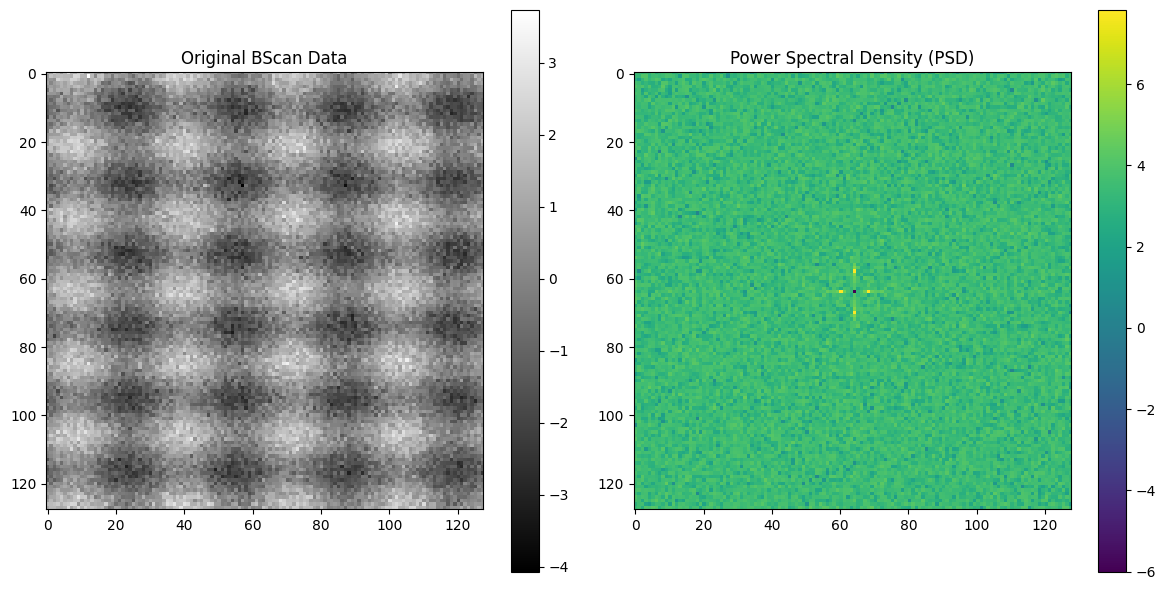

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 创建一个模拟的BScan数据矩阵 (128x128)
# 这里我们用一些正弦波来模拟周期性信号，叠加一些噪声
height, width = 128, 128
x = np.linspace(0, 2*np.pi, width)
y = np.linspace(0, 2*np.pi, height)
xx, yy = np.meshgrid(x, y)

# 模拟信号：两个不同频率的正弦波叠加
signal = np.sin(4 * xx) + np.cos(6 * yy)
# 添加噪声
bscan_data = signal + 0.5 * np.random.randn(height, width)

# 2. 数据预处理：去除直流分量
bscan_data = bscan_data - np.mean(bscan_data)

# 3. 计算二维傅里叶变换
fft_result = np.fft.fft2(bscan_data)

# 4. 计算功率谱密度 (PSD)
psd = np.abs(fft_result) ** 2

# 5. 中心化处理
psd_centered = np.fft.fftshift(psd)

# 6. 可视化结果
plt.figure(figsize=(12, 6))

# 显示原始BScan数据
plt.subplot(1, 2, 1)
plt.imshow(bscan_data, cmap='gray')
plt.title('Original BScan Data')
plt.colorbar()

# 显示功率谱 (通常用对数尺度以更好地显示细节)
plt.subplot(1, 2, 2)
plt.imshow(np.log10(psd_centered + 1e-6), cmap='viridis')
plt.title('Power Spectral Density (PSD)')
plt.colorbar()

plt.tight_layout()
plt.show()


In [4]:
import numpy as np

# 原始图像
I = np.array([[1, 2, 3],
              [3, 4, 5],
              [5, 6, 7]], dtype=np.float64)

# 方法1：手动分行列做一维FFT
row_fft = np.fft.fft(I, axis=1)  # 对每一行做FFT
col_fft = np.fft.fft(row_fft, axis=0)  # 对行FFT结果的每一列做FFT

# 方法2：直接用二维FFT
fft2_result = np.fft.fft2(I)

print("手动分行列计算结果：\n", col_fft)
print("\n直接二维FFT结果：\n", fft2_result)

# 逆变换验证数据是否一致
inverse_result = np.fft.ifft2(fft2_result)
print("\n逆变换结果：\n", inverse_result)

手动分行列计算结果：
 [[36. +0.j         -4.5+2.59807621j -4.5-2.59807621j]
 [-9. +5.19615242j  0. +0.j          0. +0.j        ]
 [-9. -5.19615242j  0. +0.j          0. +0.j        ]]

直接二维FFT结果：
 [[36. +0.j         -4.5+2.59807621j -4.5-2.59807621j]
 [-9. +5.19615242j  0. +0.j          0. +0.j        ]
 [-9. -5.19615242j  0. +0.j          0. +0.j        ]]

逆变换结果：
 [[1.+0.j 2.+0.j 3.+0.j]
 [3.+0.j 4.+0.j 5.+0.j]
 [5.+0.j 6.+0.j 7.+0.j]]
